In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from time import time

DTYPE = 'float32'

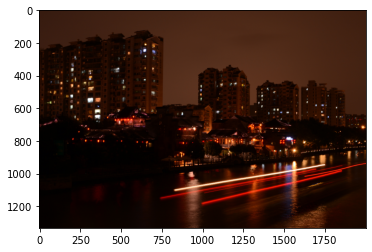

(1333, 2000, 3)


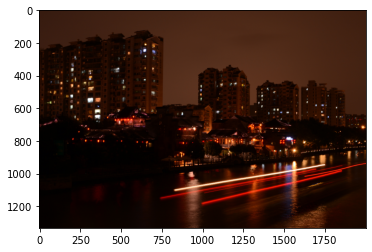

(1333, 2000, 3)


In [2]:
img = cv2.imread('CityView.jpg')
plt.imshow(img[:,:,::-1]) # reverse bgr to rgb by index
plt.show()
print(np.shape(img))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
print(img.shape)

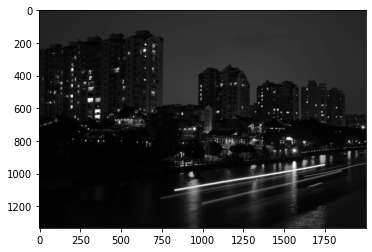

(1333, 2000)


255

In [3]:
# gray image
img = cv2.imread('CityView.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray',vmin=0, vmax=255)
plt.show()
print(np.shape(img))
np.max(img)-np.min(img)

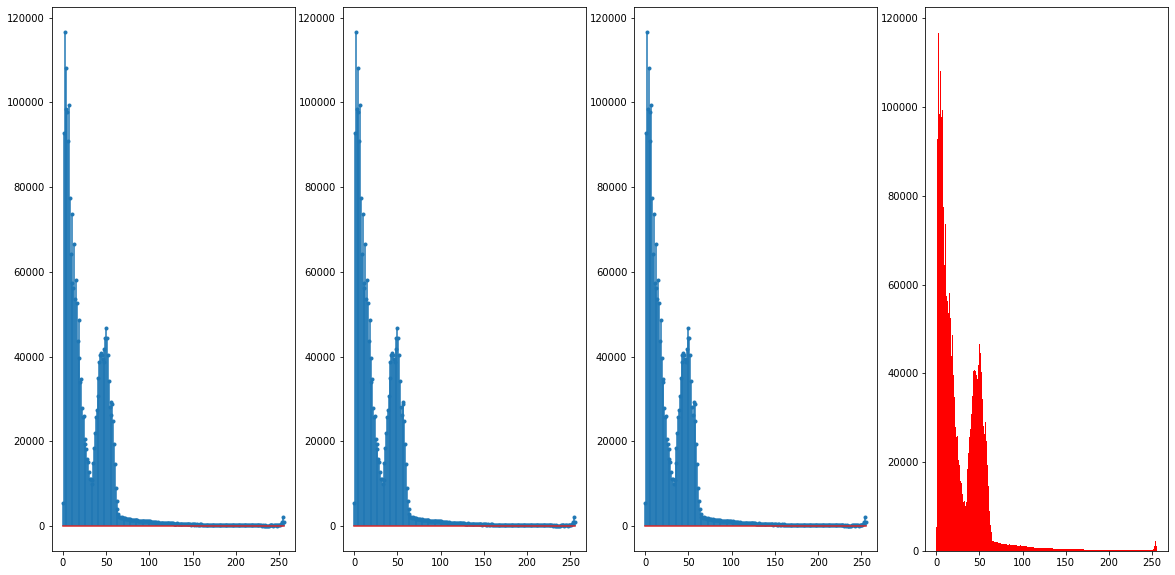

In [4]:
# three ways to construct histogram
img = cv2.imread('CityView.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
hist_cv = cv2.calcHist([img],[0],None,[256],[0,256]) # return counts in lists inside a list
hist_ = np.bincount(img.ravel(), minlength=256) # return counts in array
hist_np,bins_np = np.histogram(img.flatten(),256,[0,256]) # return both counts and index

FIG_H = 10
FIG_W = 20
plt.figure(figsize=(FIG_W, FIG_H))
plt.subplot(1,4,1)
plt.stem(range(0,256),hist_cv,markerfmt='.')
plt.subplot(1,4,2)
plt.stem(range(0,256),hist_,markerfmt='.')
plt.subplot(1,4,3)
plt.stem(range(0,256),hist_np,markerfmt='.')
plt.subplot(1,4,4)
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.show()

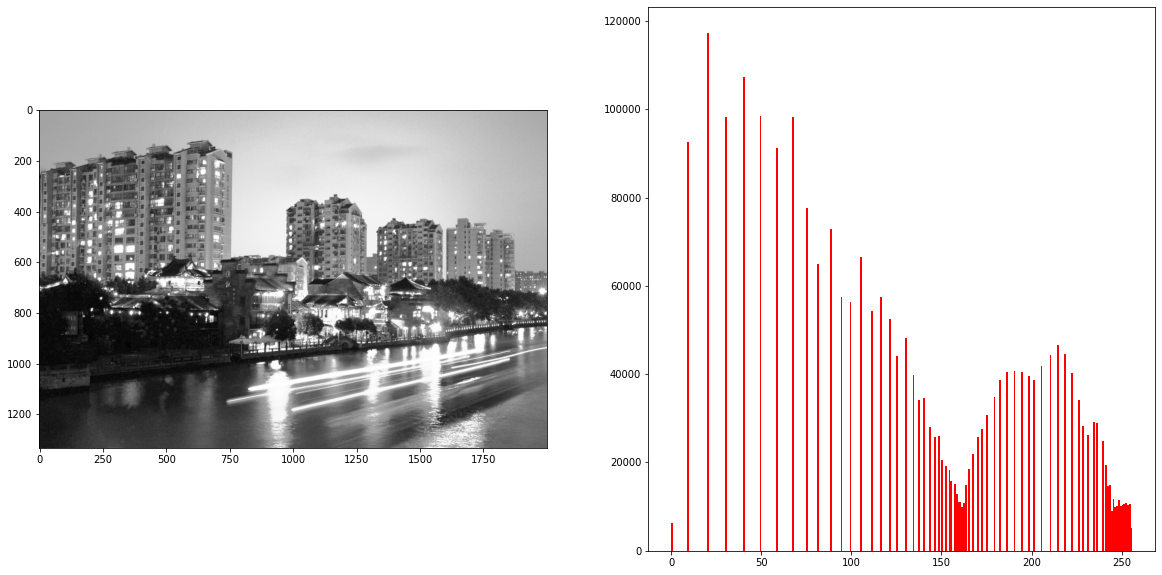

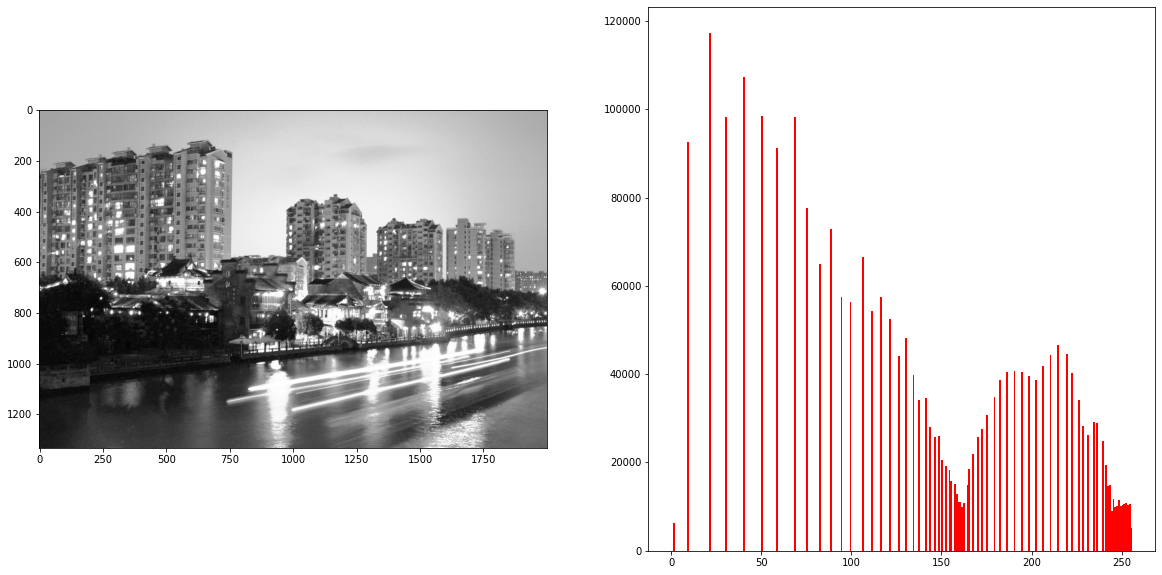

In [5]:
# histogram equalization
# 1
img = cv2.imread('CityView.jpg',0) # 0 means read in gray scale
equ_cv = cv2.equalizeHist(img)

plt.figure(figsize=(FIG_W, FIG_H))
plt.subplot(1,2,1)
plt.imshow(equ_cv,cmap='gray',vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.hist(equ_cv.flatten(),256,[0,256], color = 'r')
plt.show()

# 2
hist,bins = np.histogram(img.flatten(),256,[0,256])
hist_normalized = hist/hist.sum()
cdf = hist_normalized.cumsum() # up to 1
equ_np = np.round(cdf[img]*255) # remapping, attention to data overflow for int32
plt.figure(figsize=(FIG_W, FIG_H))
plt.subplot(1,2,1)
plt.imshow(equ_np,cmap='gray',vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.hist(equ_np.flatten(),256,[0,256], color = 'r')
plt.show()

In [19]:
# Gaussian filtering

# construct Gaussian kernel
std = 10
krnl_h = 2 * int(2 * std) + 2
krnl_w = 2 * int(2 * std) + 2
x, y = np.meshgrid(range(-krnl_w//2, krnl_w//2), range(-krnl_h//2, krnl_h//2))
gaussian_krnl = np.exp(-(x * x + y * y) / (2 * std * std)).astype('float32')
gaussian_krnl[gaussian_krnl <= np.finfo(DTYPE).eps * np.max(gaussian_krnl)] = 0
gaussian_krnl /= np.sum(gaussian_krnl)


plt.imshow(gaussian_krnl,cmap='jet')
plt.show()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y, gaussian_krnl, cmap='jet')
plt.show()

TypeError: No loop matching the specified signature and casting was found for ufunc true_divide

2d convolution time cost - 3.1512s


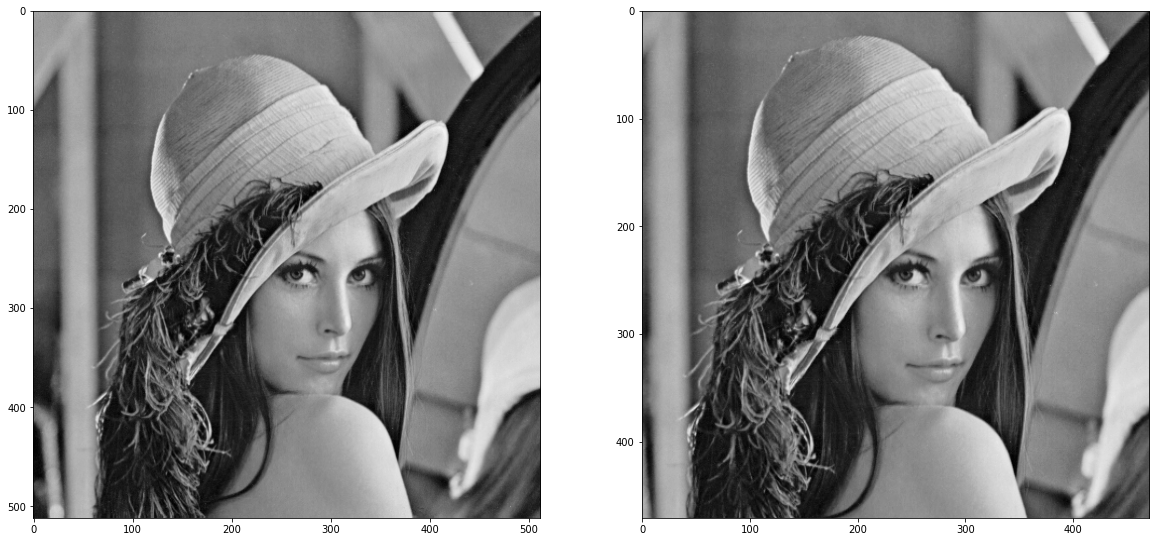

In [20]:
# DEMO II: Gaussian filtering (2)
img = cv2.imread('Lenna.png',0)
img = np.array(img)
# generalized neighbouring operation: as_strided()
start = time()
img_h, img_w = img.shape
shape = (img_h - krnl_h + 1, img_w - krnl_w + 1, krnl_h, krnl_w)
strides = np.array([img_w, 1, img_w, 1]) * img.itemsize
img_neighoured = np.lib.stride_tricks.as_strided(img, shape, strides)
result = np.sum(np.sum(img_neighoured * gaussian_krnl, -1), -1)
print(f'2d convolution time cost - {time()-start:.4f}s')

plt.figure(figsize=(FIG_W, FIG_H))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(result, cmap='gray')
plt.show()

In [21]:
# DEMO II: Gaussian filtering (3)

# warp the function as_strided() and provide a simple API
def conv2d(img, krnl):
    krnl_h, krnl_w = krnl.shape[:2]
    pad_h = (krnl_h - 1) // 2
    pad_w = (krnl_w - 1) // 2
    img = np.pad(img, [(pad_h, pad_h), (pad_w, pad_w)], 'constant')
    img_h, img_w = img.shape[:2]
    shape = (img_h - krnl_h + 1, img_w - krnl_w + 1, krnl_h, krnl_w)
    strides = np.array([img_w, 1, img_w, 1]) * img.itemsize
    img = np.lib.stride_tricks.as_strided(img, shape, strides)
    return np.tensordot(img, krnl, axes=[(2, 3), (0, 1)])

# separable gaussian kernel
def imgaussfilt(img, std_vert=0.5, std_hori=None, dtype='float32'):
    std_hori = std_vert if std_hori is None else std_hori
    x = np.arange(-int(2 * std_hori) - 1, int(2 * std_hori) + 1).astype(dtype)
    y = np.arange(-int(2 * std_vert) - 1, int(2 * std_vert) + 1).astype(dtype)
    krnl_hori = np.exp(-(x * x) / (2 * std_hori * std_hori))
    krnl_hori[krnl_hori < np.finfo(dtype).eps * np.max(krnl_hori)] = 0
    krnl_hori /= np.sum(krnl_hori)
    krnl_vert = np.exp(-(y * y) / (2 * std_vert * std_vert))
    krnl_vert[krnl_vert < np.finfo(dtype).eps * np.max(krnl_vert)] = 0
    krnl_vert /= np.sum(krnl_vert)
    return conv2d(conv2d(img, krnl_hori[None, :]), krnl_vert[:, None])

separable convolution time cost - 0.2015s


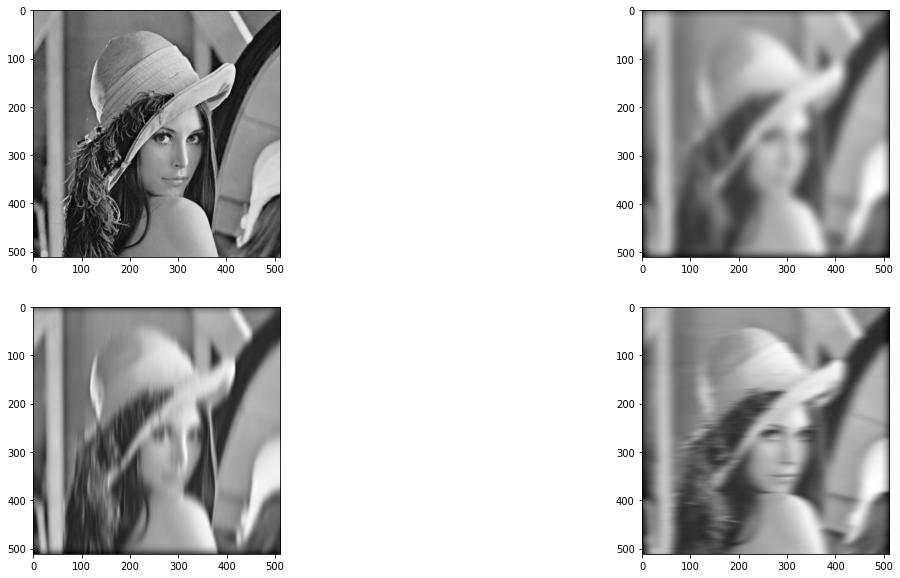

In [22]:
start = time()
result0 = imgaussfilt(img, 10)
print(f'separable convolution time cost - {time()-start:.4f}s')
result1 = imgaussfilt(img, 10, 0.5)
result2 = imgaussfilt(img, 0.5, 10)


plt.figure(figsize=(FIG_W, FIG_H))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')

plt.subplot(2, 2, 2)
plt.imshow(result0, cmap='gray')

plt.subplot(2, 2, 3)
plt.imshow(result1, cmap='gray')

plt.subplot(2, 2, 4)
plt.imshow(result2, cmap='gray')
plt.show()

In [23]:
# construct Sobel kernel

# a = np.array([[1,2],[3,4]])
# b = np.array([[5,6],[7,8]])
# print(a@b) # matrix multiplication
sobel_mean = np.array([1, 2, 1], dtype=DTYPE)
sobel_h = np.array([1, 0, -1], dtype=DTYPE)[:,None] @ sobel_mean[None, :]
print(f'`sobel_h` filter detect horizatal level line', 
      f'and calculate vertical gradient: \n{sobel_h},\n')

sobel_v = sobel_mean[:, None] @ np.array([-1, 0, 1], dtype=DTYPE)[None, :]
print(f'`sobel_v` filter detect vertical level line', 
      f'and calculate horizatal gradient: \n{sobel_v}.\n')

`sobel_h` filter detect horizatal level line and calculate vertical gradient: 
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]],

`sobel_v` filter detect vertical level line and calculate horizatal gradient: 
[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]].



2d sobel filtering time cost - 0.0189s
separabel sobel filtering time cost - 0.0100s


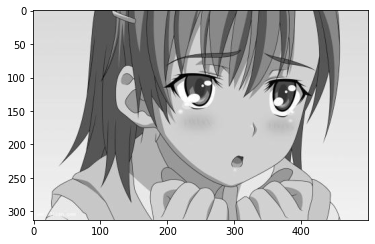

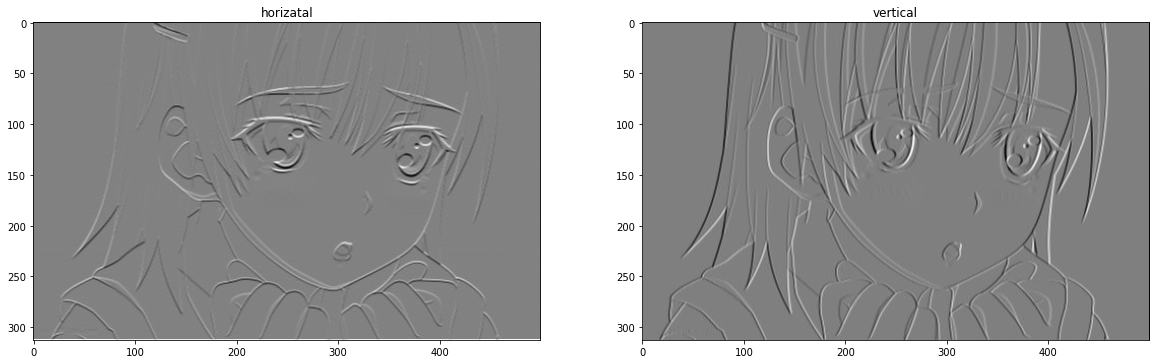

In [24]:
# Sobel filterring
img = cv2.imread('girl.jpg',0)

start = time()
horizatal = conv2d(img,sobel_h)
# vertical = conv2d(img,sobel_v)
print(f'2d sobel filtering time cost - {time()-start:.4f}s')

start = time()
vertical = conv2d(conv2d(img, sobel_mean[:,None]/4), np.array([-1,0,1], dtype=DTYPE)[None,:]/2)
print(f'separabel sobel filtering time cost - {time()-start:.4f}s')

# plt.figure(figsize=(FIG_W, FIG_H))
# plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray',vmin=0,vmax=255)
# plt.subplot(1, 2, 2)
# plt.imshow(result, cmap='gray')
plt.show()

plt.figure(figsize=(FIG_W, FIG_H))
plt.subplot(1, 2, 1)
plt.imshow(horizatal, cmap='gray'),plt.title('horizatal')

plt.subplot(1, 2, 2)
plt.imshow(vertical, cmap='gray'),plt.title('vertical')
plt.show()

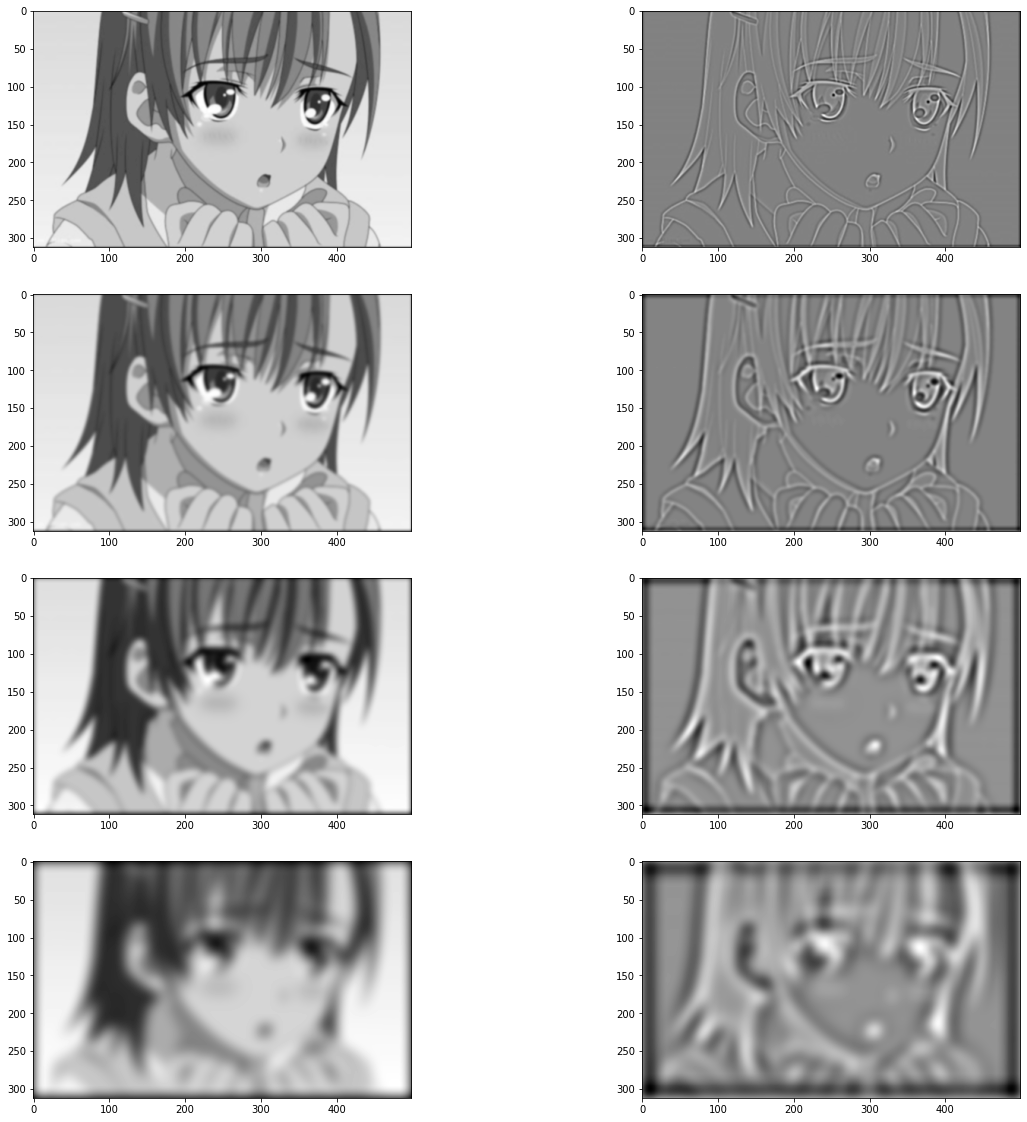

In [25]:
# DEMO IV: image pyramid
n_scales = 4
result_list = [imgaussfilt(img, pow(2, k)) for k in range(n_scales+1)]

plt.figure(figsize=(FIG_W, FIG_H * 2))
for k in range(n_scales):
    plt.subplot(n_scales, 2, 2*k+1)
    plt.imshow(result_list[k], cmap='gray')
    plt.subplot(n_scales, 2, 2*k+2)
    plt.imshow(result_list[k+1]-result_list[k], cmap='gray')
plt.show()
